In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random
import matplotlib.gridspec as gridspec

def plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title):
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)

    # Load data
    train_data = pd.read_csv(train_data_path, delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
    test_data = pd.read_csv(test_data_path, delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
    user_emb = torch.load(user_emb_path, map_location=torch.device('cpu'))
    item_emb = torch.load(item_emb_path, map_location=torch.device('cpu'))

    # Calculate popularity
    combined_data = pd.concat([train_data, test_data])
    user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
    item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

    # Define thresholds for hot and cold sampling
    user_hot_threshold = user_popularity['interaction'].quantile(0.95)
    user_cold_threshold = user_popularity['interaction'].quantile(0.80)
    item_hot_threshold = item_popularity['interaction'].quantile(0.95)
    item_cold_threshold = item_popularity['interaction'].quantile(0.80)

    # Sample hot and cold users/items
    hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
    cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
    hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
    cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

    # Ensure that user and item ids are within the valid index range
    valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
    valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

    hot_users = hot_users[valid_user_ids]
    hot_items = hot_items[valid_item_ids]

    valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
    valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

    cold_users = cold_users[valid_user_ids]
    cold_items = cold_items[valid_item_ids]

    # Now extract embeddings
    hot_user_emb = user_emb[hot_users['user_id'].values]
    cold_user_emb = user_emb[cold_users['user_id'].values]
    hot_item_emb = item_emb[hot_items['item_id'].values]
    cold_item_emb = item_emb[cold_items['item_id'].values]

    # Combine and map to 2D using t-SNE
    combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
    combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
    tsne = TSNE(n_components=2, random_state=42)
    user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
    item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

    angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
    angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
    angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
    angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

    # Set the size of the plots in pixels
    dpi = 100
    fig_width = 450 / dpi  # 450 pixels / 100 dpi = 4.5 inches
    fig_height = (450 + 150) / dpi  # (450 pixels + 150 pixels) / 100 dpi = 6 inches

    # Create a new figure for both the scatter and KDE plots
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 0.65])

    ax0 = plt.subplot(gs[0, 0])
    ax0.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
    ax0.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
    ax0.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
    ax0.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')
    # ax0.set_title("XSimGCL_WE")
    ax0.set_title(title)
    ax0.set_xlabel("Feature")
    ax0.set_ylabel("Feature")

    ax1 = plt.subplot(gs[1, 0])
    sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users', ax=ax1)
    sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users', ax=ax1)
    sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items', ax=ax1)
    sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items', ax=ax1)
    ax1.set_xlabel("Angle")
    ax1.set_ylabel("Density")
    ax1.set_ylim(0, 0.5)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)

    # Save the plot
    plt.savefig(output_path)
    plt.show()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random
import matplotlib.gridspec as gridspec

def plot_embeddings2(train_data_path, test_data_path, user_emb_path_p_u, user_emb_path_u, user_emb_path_p_i, user_emb_path_i, output_path, title):
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)

    # Load data
    train_data = pd.read_csv(train_data_path, delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
    test_data = pd.read_csv(test_data_path, delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
    
    best_p_u = torch.load(user_emb_path_p_u, map_location=torch.device('cpu'))
    best_u = torch.load(user_emb_path_u, map_location=torch.device('cpu'))
    best_p_i = torch.load(user_emb_path_p_i, map_location=torch.device('cpu'))
    best_i = torch.load(user_emb_path_i, map_location=torch.device('cpu'))
    
    user_emb = best_p_u + best_u
    item_emb = best_p_i + best_i

    # Calculate popularity
    combined_data = pd.concat([train_data, test_data])
    user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
    item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

    # Define thresholds for hot and cold sampling
    user_hot_threshold = user_popularity['interaction'].quantile(0.95)
    user_cold_threshold = user_popularity['interaction'].quantile(0.80)
    item_hot_threshold = item_popularity['interaction'].quantile(0.95)
    item_cold_threshold = item_popularity['interaction'].quantile(0.80)

    # Sample hot and cold users/items
    hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
    cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
    hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
    cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

    # Ensure that user and item ids are within the valid index range
    valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
    valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

    hot_users = hot_users[valid_user_ids]
    hot_items = hot_items[valid_item_ids]

    valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
    valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

    cold_users = cold_users[valid_user_ids]
    cold_items = cold_items[valid_item_ids]

    # Now extract embeddings
    hot_user_emb = user_emb[hot_users['user_id'].values]
    cold_user_emb = user_emb[cold_users['user_id'].values]
    hot_item_emb = item_emb[hot_items['item_id'].values]
    cold_item_emb = item_emb[cold_items['item_id'].values]

    # Combine and map to 2D using t-SNE
    combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
    combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
    tsne = TSNE(n_components=2, random_state=42)
    user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
    item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

    angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
    angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
    angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
    angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

    # Set the size of the plots in pixels
    dpi = 100
    fig_width = 450 / dpi  # 450 pixels / 100 dpi = 4.5 inches
    fig_height = (450 + 150) / dpi  # (450 pixels + 150 pixels) / 100 dpi = 6 inches

    # Create a new figure for both the scatter and KDE plots
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 0.65])

    ax0 = plt.subplot(gs[0, 0])
    ax0.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
    ax0.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
    ax0.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
    ax0.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')
    # ax0.set_title("XSimGCL_WE")
    ax0.set_title(title)
    ax0.set_xlabel("Feature")
    ax0.set_ylabel("Feature")

    ax1 = plt.subplot(gs[1, 0])
    sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users', ax=ax1)
    sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users', ax=ax1)
    sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items', ax=ax1)
    sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items', ax=ax1)
    ax1.set_xlabel("Angle")
    ax1.set_ylabel("Density")
    ax1.set_ylim(0, 0.5)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)

    # Save the plot
    plt.savefig(output_path)
    plt.show()

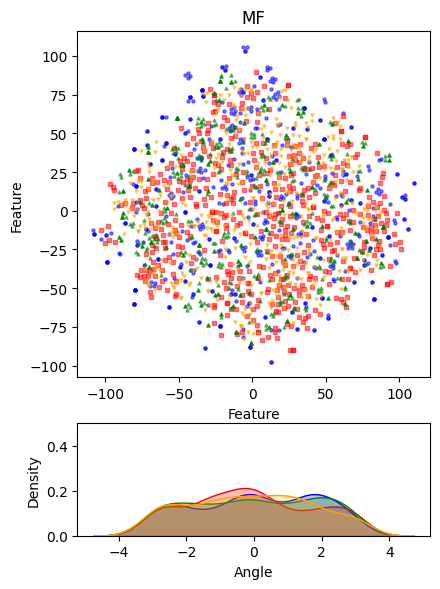

In [12]:
# Define file paths
title = 'MF'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/base/MF_MovieLens-1m/best_user_emb.pt'
item_emb_path = './embedding/base/MF_MovieLens-1m/best_item_emb.pt'
output_path = './embedding/base/MF_MovieLens-1m/MF.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

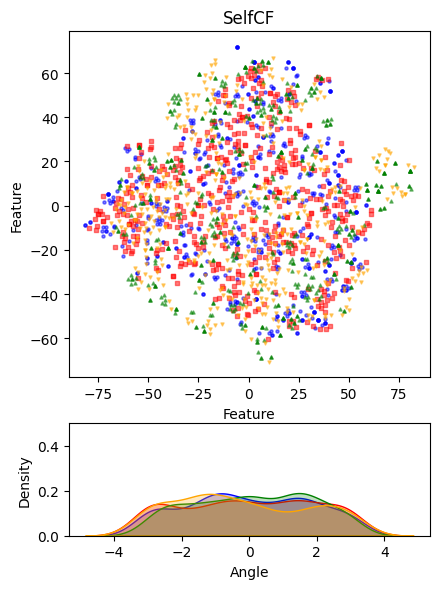

In [13]:
# Define file paths
title = 'SelfCF'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path_p_u = './embedding/base/SelfCF_MovieLens-1m/best_p_u.pt'
user_emb_path_u = './embedding/base/SelfCF_MovieLens-1m/best_u.pt'
user_emb_path_p_i = './embedding/base/SelfCF_MovieLens-1m/best_p_i.pt'
user_emb_path_i = './embedding/base/SelfCF_MovieLens-1m/best_i.pt'
output_path = './embedding/base/SelfCF_MovieLens-1m/SelfCF.png'
 
# Generate and save the plot
plot_embeddings2(train_data_path, test_data_path, user_emb_path_p_u, user_emb_path_u, user_emb_path_p_i, user_emb_path_i, output_path, title)

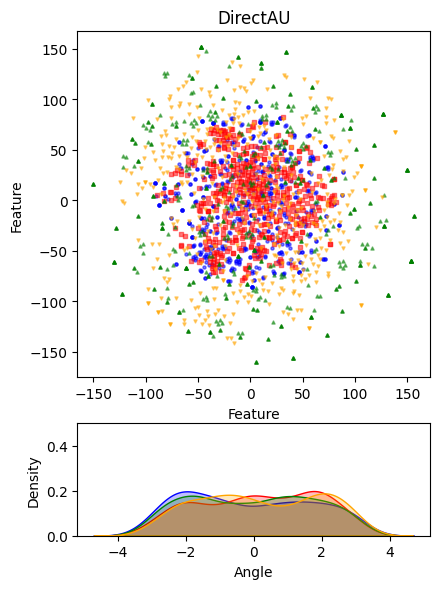

In [14]:
# Define file paths
title = 'DirectAU'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/base/DirectAU_MovieLens-1m/best_user_emb.pt'
item_emb_path = './embedding/base/DirectAU_MovieLens-1m/best_item_emb.pt'
output_path = './embedding/base/DirectAU_MovieLens-1m/DirectAU.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

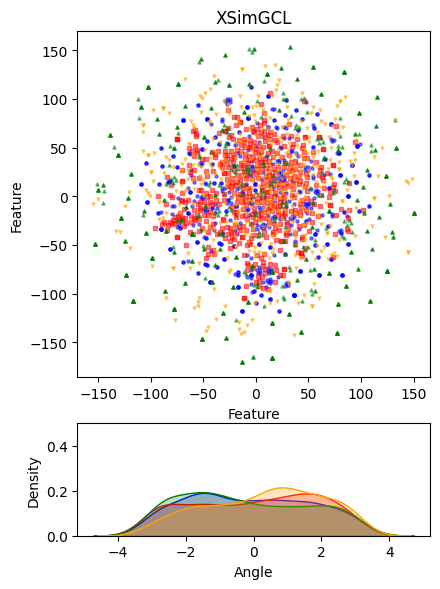

In [15]:
# Define file paths
title = 'XSimGCL'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/base/XSimGCL_MovieLens-1m/best_user_emb.pt'
item_emb_path = './embedding/base/XSimGCL_MovieLens-1m/best_item_emb.pt'
output_path = './embedding/base/XSimGCL_MovieLens-1m/XSimGCL.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

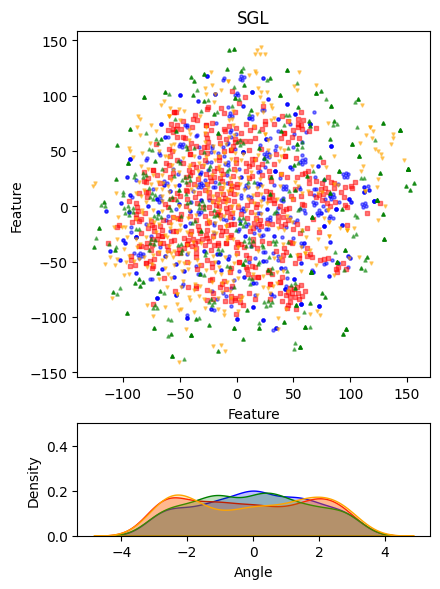

In [16]:
# Define file paths
title = 'SGL'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/base/SGL_MovieLens-1m/best_user_emb.pt'
item_emb_path = './embedding/base/SGL_MovieLens-1m/best_item_emb.pt'
output_path = './embedding/base/SGL_MovieLens-1m/SGL.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

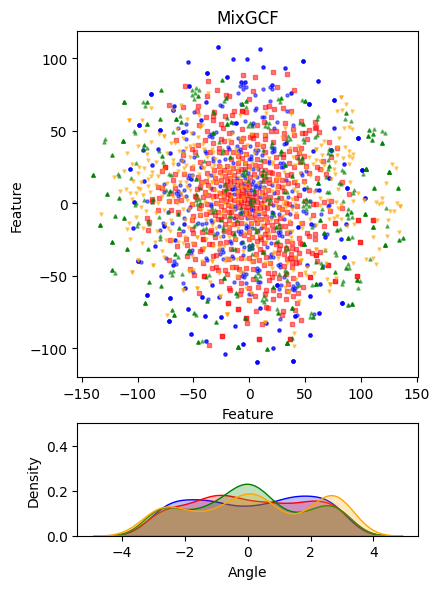

In [17]:
# Define file paths
title = 'MixGCF'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/base/MixGCF_MovieLens-1m/best_user_emb.pt'
item_emb_path = './embedding/base/MixGCF_MovieLens-1m/best_item_emb.pt'
output_path = './embedding/base/MixGCF_MovieLens-1m/MixGCF.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

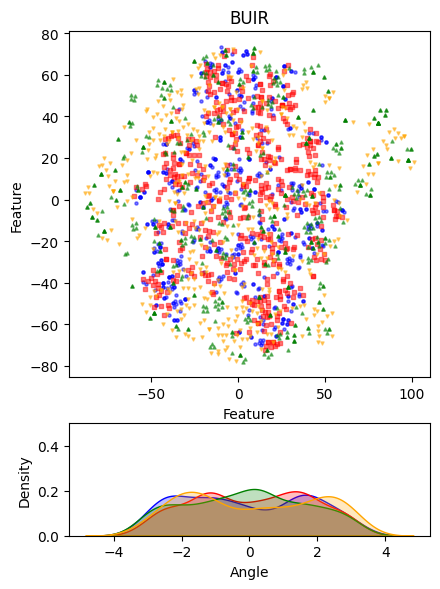

In [18]:
# Define file paths
title = 'BUIR'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path_p_u = './embedding/base/BUIR_MovieLens-1m/best_p_u.pt'
user_emb_path_u = './embedding/base/BUIR_MovieLens-1m/best_u.pt'
user_emb_path_p_i = './embedding/base/BUIR_MovieLens-1m/best_p_i.pt'
user_emb_path_i = './embedding/base/BUIR_MovieLens-1m/best_i.pt'
output_path = './embedding/base/BUIR_MovieLens-1m/BUIR.png'
 
# Generate and save the plot
plot_embeddings2(train_data_path, test_data_path, user_emb_path_p_u, user_emb_path_u, user_emb_path_p_i, user_emb_path_i, output_path, title)

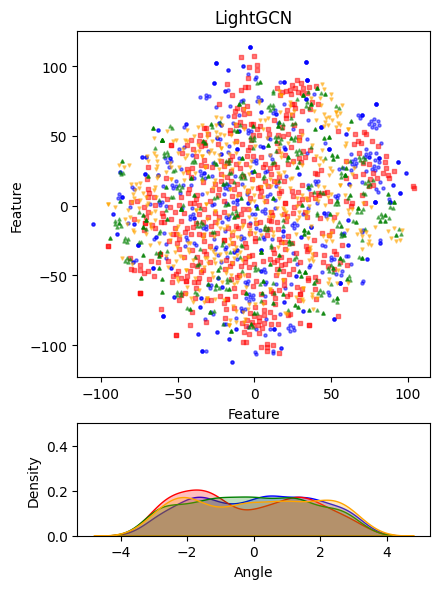

In [19]:
# Define file paths
title = 'LightGCN'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/base/LightGCN_MovieLens-1m/best_user_emb.pt'
item_emb_path = './embedding/base/LightGCN_MovieLens-1m/best_item_emb.pt'
output_path = './embedding/base/LightGCN_MovieLens-1m/LightGCN.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

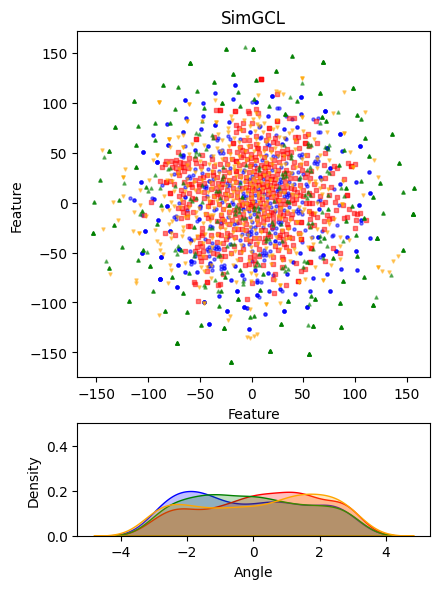

In [20]:
# Define file paths
title = 'SimGCL'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/base/SimGCL_MovieLens-1m/best_user_emb.pt'
item_emb_path = './embedding/base/SimGCL_MovieLens-1m/best_item_emb.pt'
output_path = './embedding/base/SimGCL_MovieLens-1m/SimGCL.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

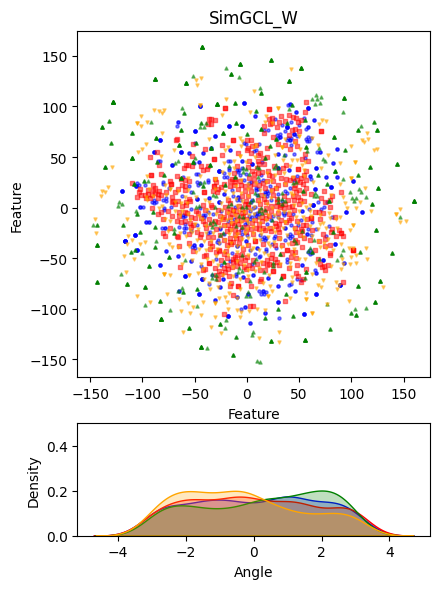

In [21]:
# Define file paths
title = 'SimGCL_W'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/Weight/SimGCL_Weight/ml-1m/best_user_emb.pt'
item_emb_path = './embedding/Weight/SimGCL_Weight/ml-1m/best_item_emb.pt'
output_path = './embedding/Weight/SimGCL_Weight/ml-1m/SimGCL_W.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

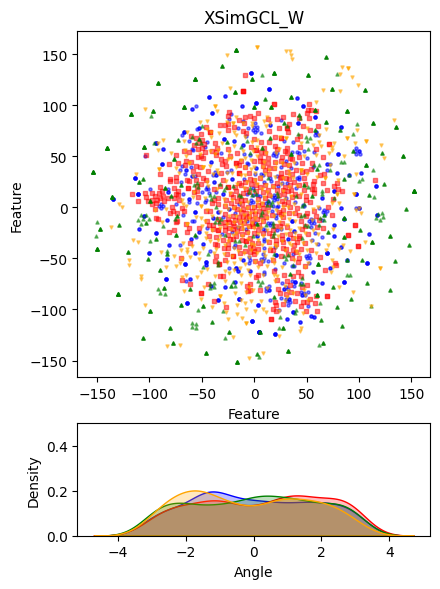

In [22]:
# Define file paths
title = 'XSimGCL_W'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/Weight/XSimGCL_Weight/ml-1m/best_user_emb.pt'
item_emb_path = './embedding/Weight/XSimGCL_Weight/ml-1m/best_item_emb.pt'
output_path = './embedding/Weight/XSimGCL_Weight/ml-1m/XSimGCL_W.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

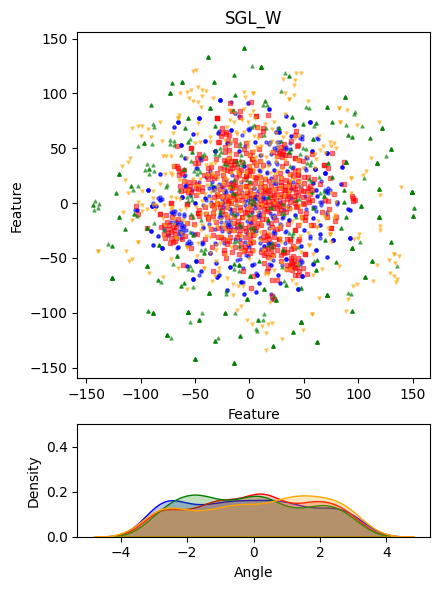

In [23]:
# Define file paths
title = 'SGL_W'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/Weight/SGL_Weight/ml-1m/best_user_emb.pt'
item_emb_path = './embedding/Weight/SGL_Weight/ml-1m/best_item_emb.pt'
output_path = './embedding/Weight/SGL_Weight/ml-1m/SGL_W.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

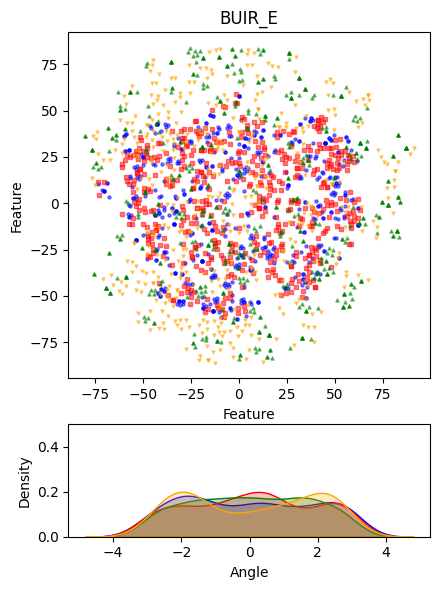

In [24]:
# Define file paths
title = 'BUIR_E'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path_p_u = './embedding/Egress/BUIR_Egress/ml-1m/best_p_u.pt'
user_emb_path_u = './embedding/Egress/BUIR_Egress/ml-1m/best_u.pt'
user_emb_path_p_i = './embedding/Egress/BUIR_Egress/ml-1m/best_p_i.pt'
user_emb_path_i = './embedding/Egress/BUIR_Egress/ml-1m/best_i.pt'
output_path = './embedding/Egress/BUIR_Egress/ml-1m/BUIR_E.png'
 
# Generate and save the plot
plot_embeddings2(train_data_path, test_data_path, user_emb_path_p_u, user_emb_path_u, user_emb_path_p_i, user_emb_path_i, output_path, title)

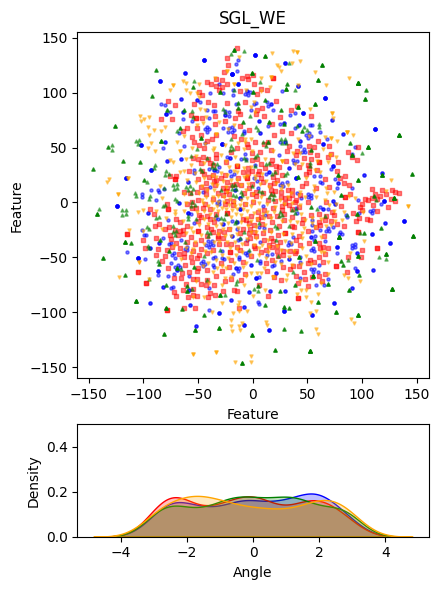

In [25]:
# Define file paths
title = 'SGL_WE'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/Weight_Egress/MixGCF_Weight_Egress/ml-1m/best_user_emb.pt'
item_emb_path = './embedding/Weight_Egress/MixGCF_Weight_Egress/ml-1m/best_item_emb.pt'
output_path = './embedding/Weight_Egress/MixGCF_Weight_Egress/ml-1m/MixGCF_WE.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)

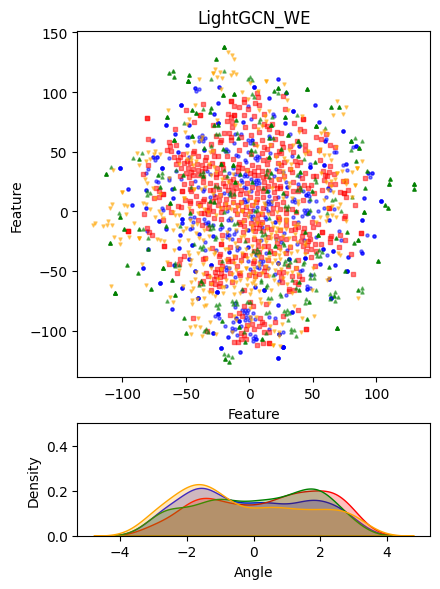

In [26]:
# Define file paths
title = 'LightGCN_WE'
train_data_path = './dataset/ml-1m/train.txt'
test_data_path = './dataset/ml-1m/test.txt'
user_emb_path = './embedding/Weight_Egress/LightGCN_Weight_Egress/ml-1m/best_user_emb.pt'
item_emb_path = './embedding/Weight_Egress/LightGCN_Weight_Egress/ml-1m/best_item_emb.pt'
output_path = './embedding/Weight_Egress/LightGCN_Weight_Egress/ml-1m/LightGCN_WE.png'

# Generate and save the plot
plot_embeddings(train_data_path, test_data_path, user_emb_path, item_emb_path, output_path, title)